In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


**Problem Statement: predict a system’s probability of getting infected by various families of malware, based on different properties of that system. The telemetry data containing these properties and the system infections was generated by threat reports collected by system's antivirus software.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from category_encoders import TargetEncoder, CountEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold


### Loading Dataset

In [3]:
train_data = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
test_data = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")
submission_data = pd.read_csv("/kaggle/input/System-Threat-Forecaster/sample_submission.csv")

## Exploratory Data Analysis

In [4]:
print("\nTrain Data Info:")
train_data.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm   

In [5]:
print("\nTest Data Info:")
test_data.info()


Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 75 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MachineID                           10000 non-null  object 
 1   ProductName                         10000 non-null  object 
 2   EngineVersion                       10000 non-null  object 
 3   AppVersion                          10000 non-null  object 
 4   SignatureVersion                    10000 non-null  object 
 5   IsBetaUser                          10000 non-null  int64  
 6   RealTimeProtectionState             9991 non-null   float64
 7   IsPassiveModeEnabled                10000 non-null  int64  
 8   AntivirusConfigID                   9998 non-null   float64
 9   NumAntivirusProductsInstalled       9998 non-null   float64
 10  NumAntivirusProductsEnabled         9998 non-null   float64
 11  HasTpm                   

In [6]:
train_data.shape,test_data.shape

((100000, 76), (10000, 75))

### Check for missing values

In [7]:
# Check for missing values
missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nMissing Values in Train Data:")
print(missing_values)




Missing Values in Train Data:
SMode                                 981
CityID                                623
IsGamer                               559
RegionIdentifier                      559
InternalBatteryNumberOfCharges        515
FirmwareManufacturerID                376
FirmwareVersionID                     334
IsFlightsDisabled                     326
OEMModelID                            228
OEMNameID                             212
FirewallEnabled                       166
TotalPhysicalRAMMB                    151
IsAlwaysOnAlwaysConnectedCapable      134
OSInstallLanguageID                   113
SystemVolumeCapacityMB                110
PrimaryDiskCapacityMB                 110
IEVersionID                           107
ProcessorModelID                       85
ProcessorManufacturerID                85
ProcessorCoreCount                     85
AntivirusConfigID                      76
IsSystemProtected                      76
NumAntivirusProductsEnabled            76
Num

In [8]:
# Check for missing values
missing_values = test_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nMissing Values in Train Data:")
print(missing_values)


Missing Values in Train Data:
SMode                                 92
RegionIdentifier                      62
IsGamer                               62
CityID                                61
InternalBatteryNumberOfCharges        54
IsFlightsDisabled                     35
FirmwareManufacturerID                32
FirmwareVersionID                     29
OEMModelID                            21
OEMNameID                             18
FirewallEnabled                       16
OSInstallLanguageID                   14
IsAlwaysOnAlwaysConnectedCapable      12
TotalPhysicalRAMMB                    12
ProcessorCoreCount                    11
ProcessorModelID                      11
ProcessorManufacturerID               11
PrimaryDiskCapacityMB                 10
SystemVolumeCapacityMB                10
IEVersionID                           10
RealTimeProtectionState                9
IsVirtualDevice                        7
PrimaryDisplayDiagonalInches           6
PrimaryDisplayResolutionHo

In [9]:
train_data.head

<bound method NDFrame.head of                               MachineID   ProductName EngineVersion  \
0      f541bae429089117c4aac39c90dd3416  win8defender   1.1.15200.1   
1      dc2b14d9ce3a0ce4050bb640190f2ca5  win8defender   1.1.15100.1   
2      fd20c5f010e9c5f91ad1c6b3e0da68a0  win8defender   1.1.15200.1   
3      38711eae85eb77a72ec5dfdf27eb2a76  win8defender   1.1.15200.1   
4      32607c9a543a9214e2c7e45800ed4849  win8defender   1.1.15200.1   
...                                 ...           ...           ...   
99995  a378b2196a7a1d8ee0d4f989ee46730e  win8defender   1.1.15200.1   
99996  7f4433ca05d24b9bbdd3932f8b05e61f  win8defender   1.1.15100.1   
99997  d6852dfff534e03d5ddfd3c7875ab072  win8defender   1.1.15200.1   
99998  70a8dc682128c9ff78a3de5aea9dac74  win8defender   1.1.14901.4   
99999  ad9c385b53f2ca788933a39603b84eda  win8defender   1.1.15000.2   

             AppVersion SignatureVersion  IsBetaUser  RealTimeProtectionState  \
0       4.18.1807.18075     1.275.10

In [10]:
# Summary statistics of numerical features
print("\nNumerical Feature Summary:")
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_rows", None)
print(train_data.describe())


Numerical Feature Summary:
       IsBetaUser  RealTimeProtectionState  IsPassiveModeEnabled  \
count    100000.0             99934.000000         100000.000000   
mean          0.0                 6.848430              0.017620   
std           0.0                 1.015166              0.131566   
min           0.0                 0.000000              0.000000   
25%           0.0                 7.000000              0.000000   
50%           0.0                 7.000000              0.000000   
75%           0.0                 7.000000              0.000000   
max           0.0                 8.000000              1.000000   

       AntivirusConfigID  NumAntivirusProductsInstalled  \
count       99924.000000                   99924.000000   
mean        47975.710440                       1.326528   
std         13803.321533                       0.520681   
min            39.000000                       1.000000   
25%         49480.000000                       1.000000   
50%  

In [11]:
# Check unique values in each column
unique_values = train_data.nunique()
unique_values = unique_values[unique_values > 0].sort_values(ascending=False)
print("\nUnique Values per Column in Train Data:")
print(unique_values)


Unique Values per Column in Train Data:
MachineID                             99835
SystemVolumeCapacityMB                46188
CityID                                16047
OEMModelID                            15952
FirmwareVersionID                     12299
SignatureVersion                       2735
DateAS                                 2695
AntivirusConfigID                      1976
InternalBatteryNumberOfCharges         1760
ProcessorModelID                       1659
OEMNameID                               837
PrimaryDiskCapacityMB                   398
PrimaryDisplayDiagonalInches            362
OSBuildLab                              281
GeoRegionID                             239
NumericOSVersion                        221
CountryID                               220
OSBuildRevisionOnly                     199
LocaleEnglishNameID                     185
FirmwareManufacturerID                  169
PrimaryDisplayResolutionVertical        131
TotalPhysicalRAMMB                 

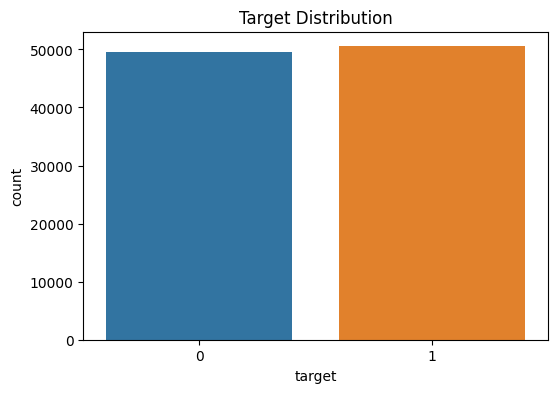

In [12]:
# Analyze target distribution
plt.figure(figsize=(6,4))
sns.countplot(x=train_data['target'])
plt.title("Target Distribution")
plt.show()

In [13]:
train_data['target'].value_counts(normalize=True)


target
1    0.50525
0    0.49475
Name: proportion, dtype: float64

*Target variable is balanced*

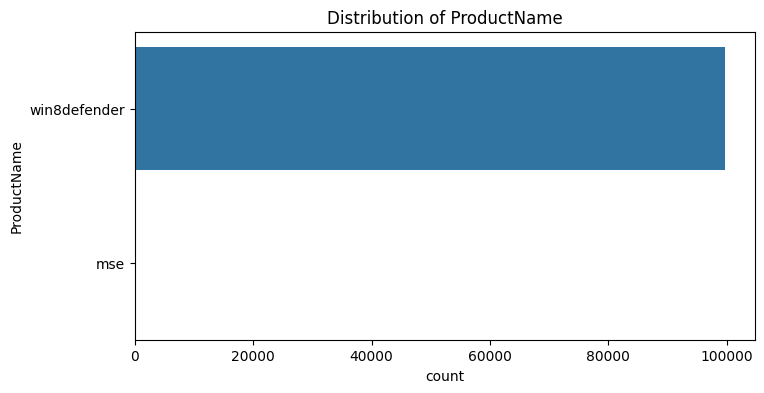

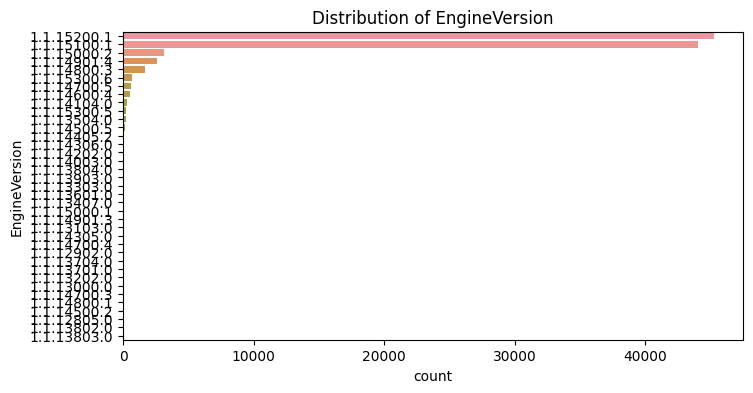

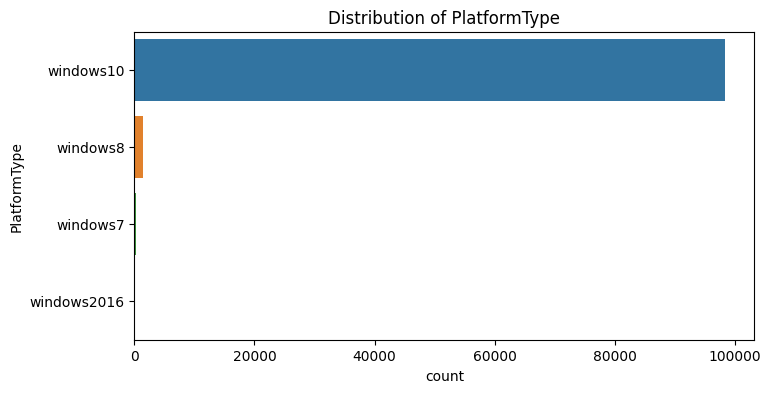

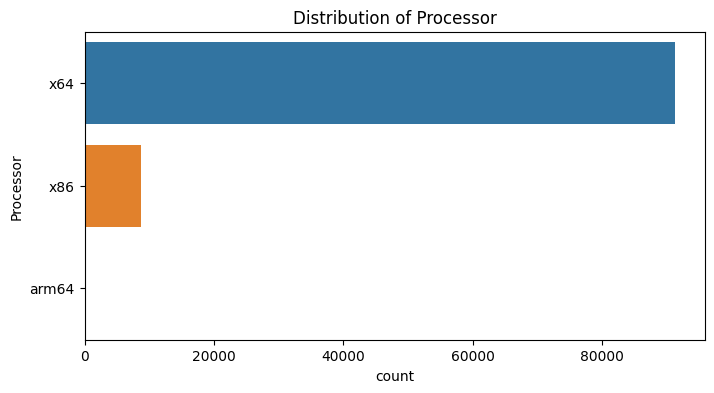

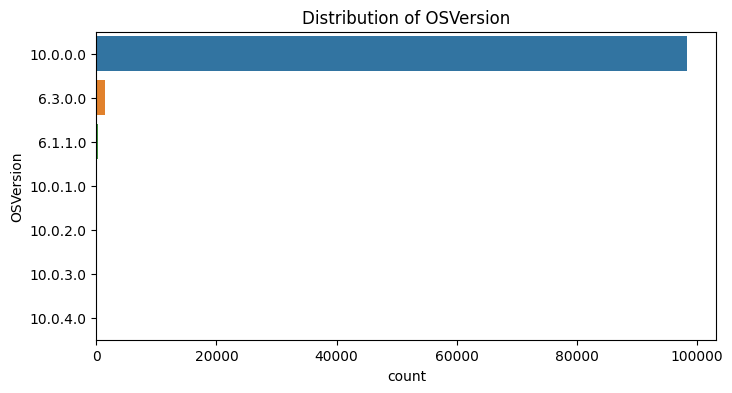

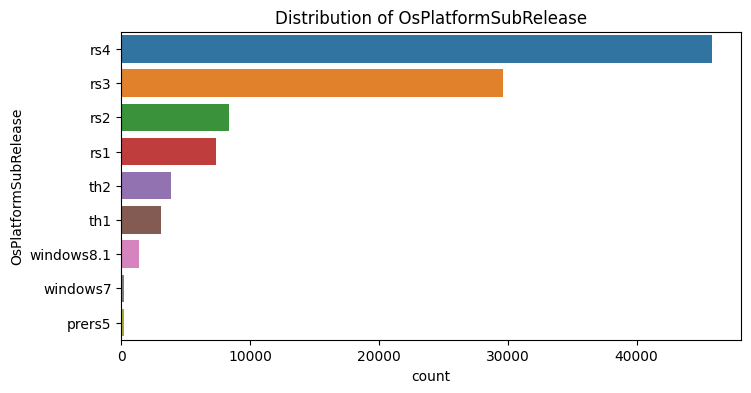

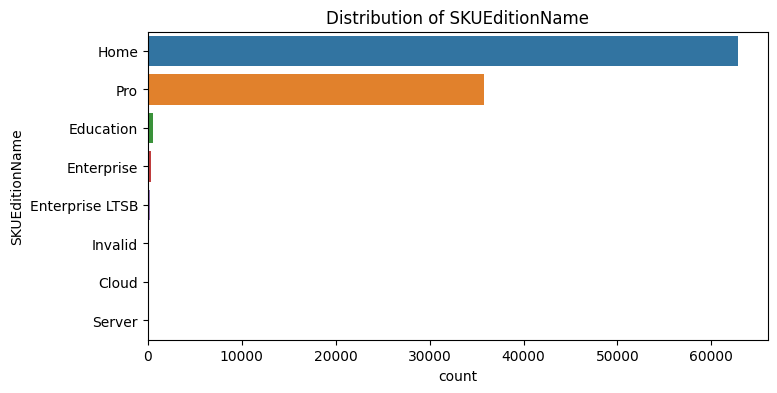

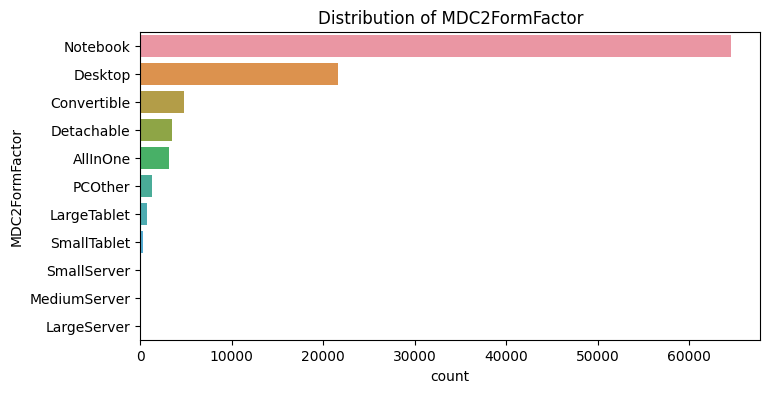

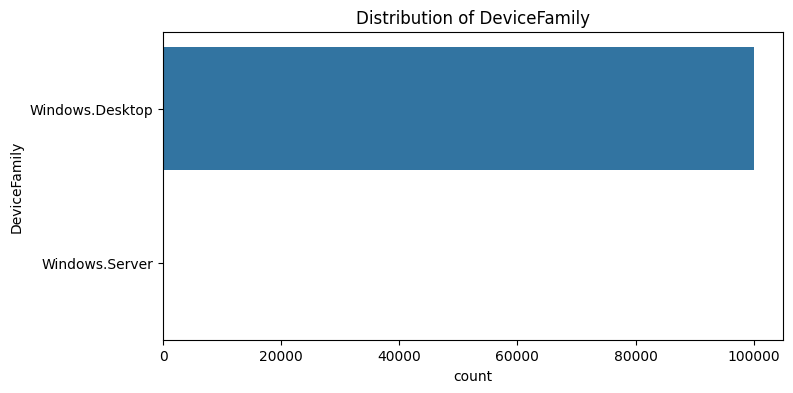

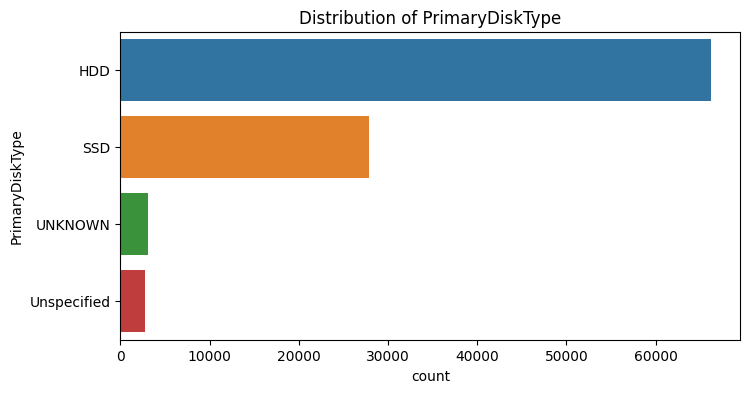

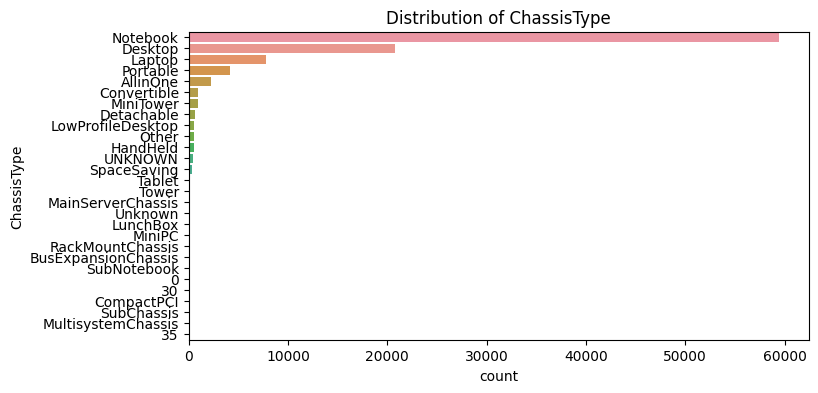

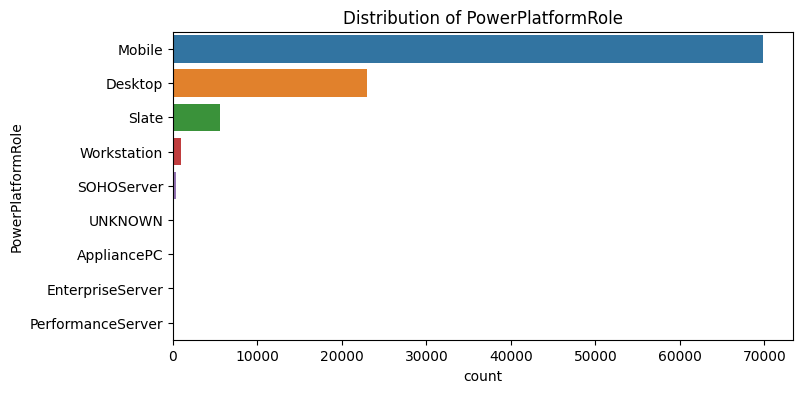

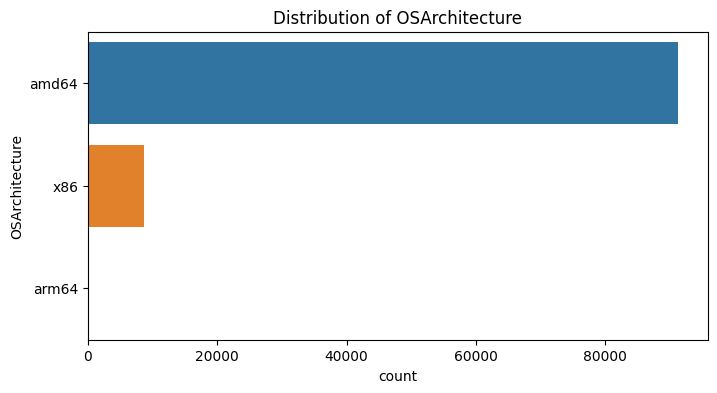

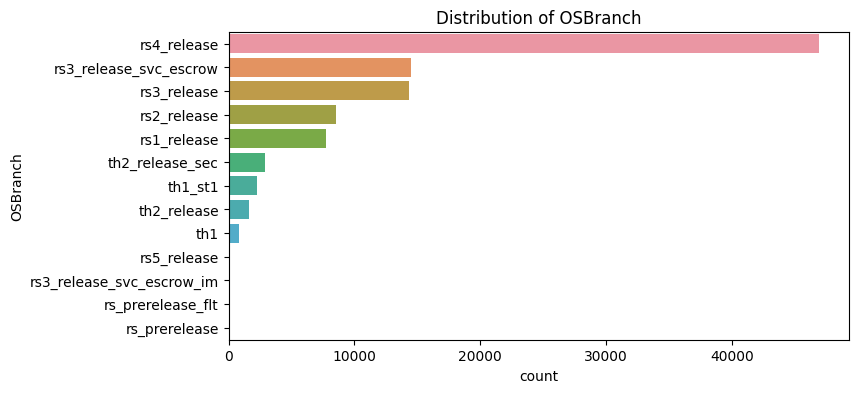

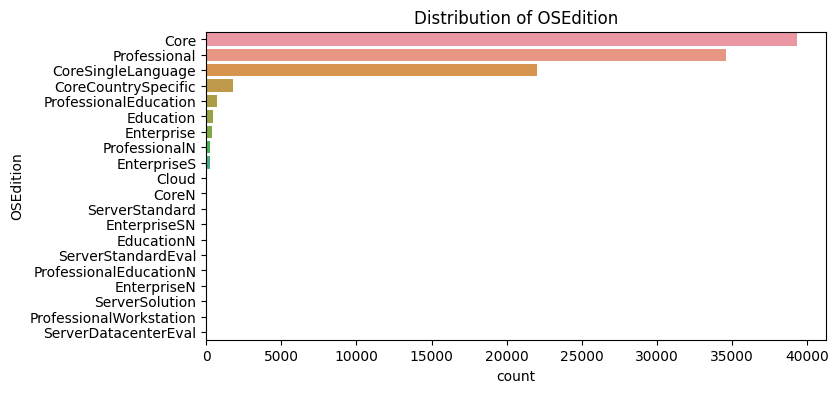

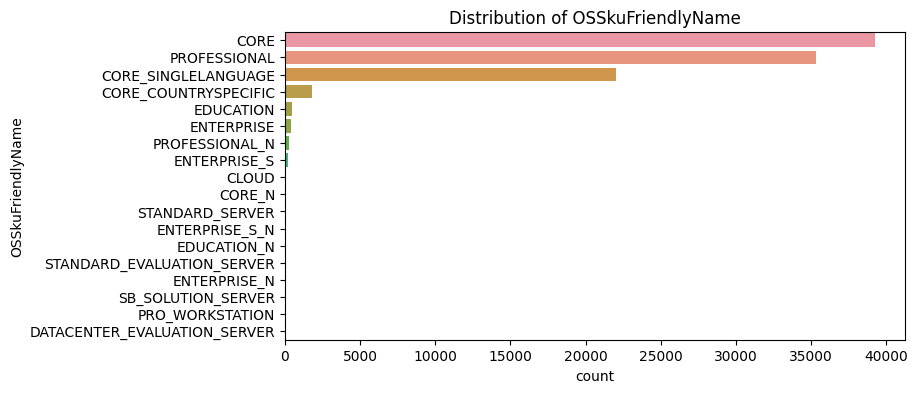

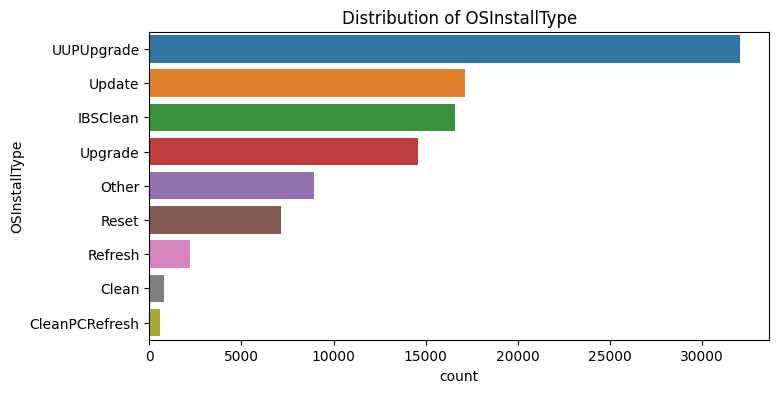

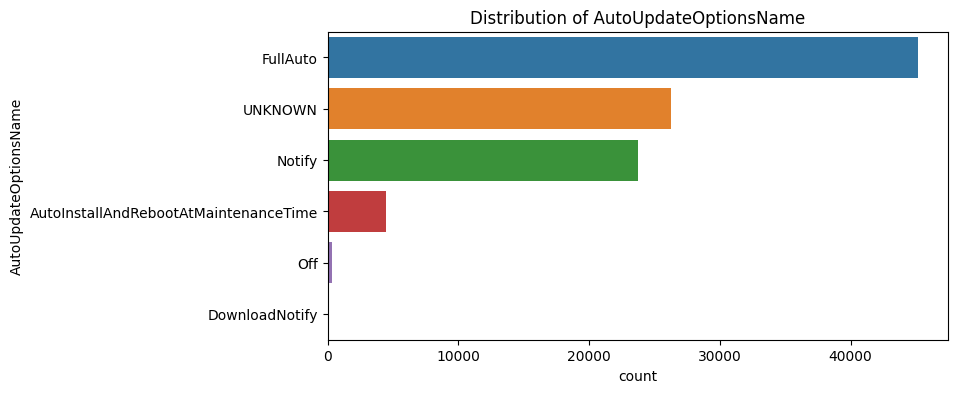

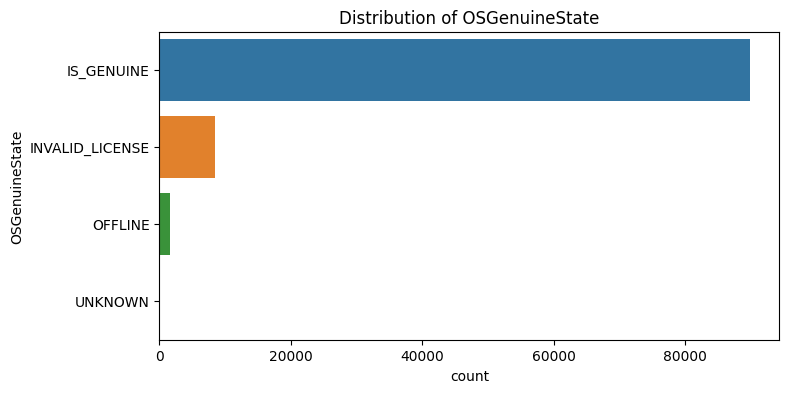

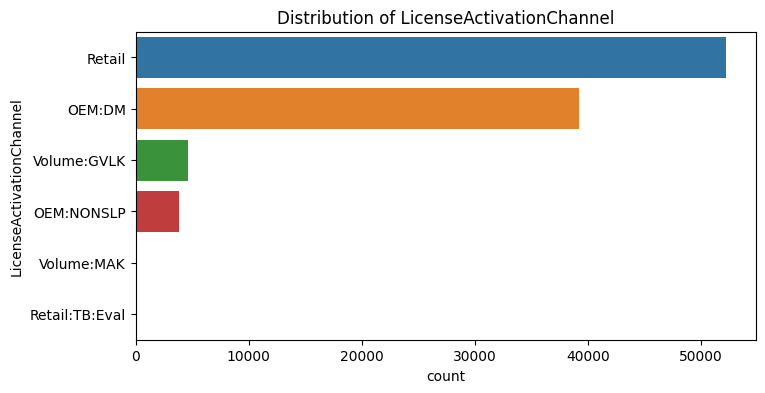

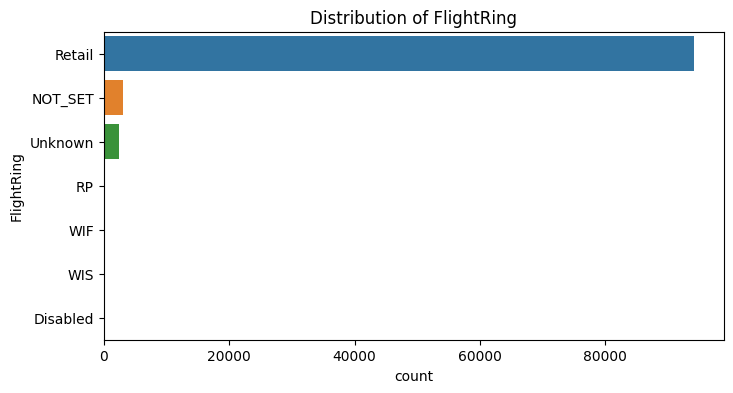

In [14]:
cat_cols = ['ProductName', 'EngineVersion','PlatformType', 'Processor', 'OSVersion',
       'OsPlatformSubRelease', 'SKUEditionName',
       'MDC2FormFactor', 'DeviceFamily', 'PrimaryDiskType', 'ChassisType',
       'PowerPlatformRole', 'OSArchitecture', 'OSBranch',
       'OSEdition', 'OSSkuFriendlyName', 'OSInstallType',
       'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel',
       'FlightRing']
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=train_data[col], order=train_data[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


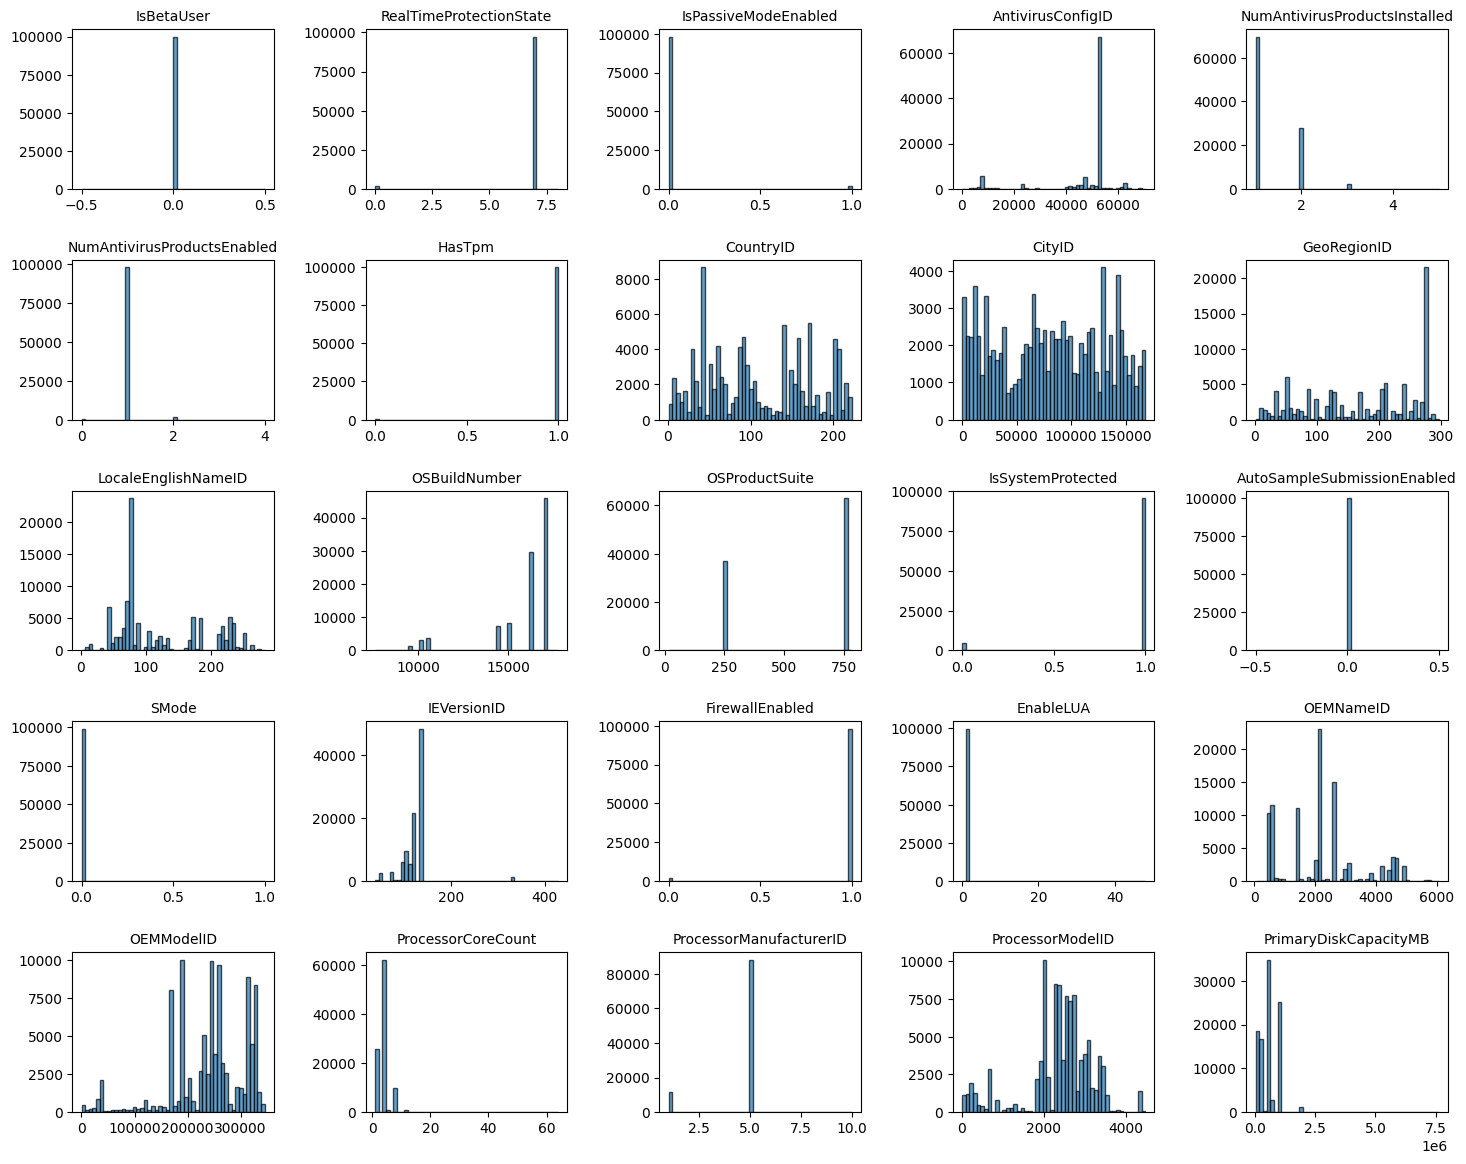

In [15]:
num_cols = ['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled',
       'AntivirusConfigID', 'NumAntivirusProductsInstalled',
       'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID',
       'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite',
       'IsSystemProtected', 'AutoSampleSubmissionEnabled', 'SMode',
       'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID',
       'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID',
       'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB',
       'HasOpticalDiskDrive', 'TotalPhysicalRAMMB',
       'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutionVertical', 'InternalBatteryNumberOfCharges',
       'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OSInstallLanguageID',
       'OSUILocaleID', 'IsPortableOS', 'IsFlightsDisabled',
       'FirmwareManufacturerID', 'FirmwareVersionID', 'IsSecureBootEnabled',
       'IsVirtualDevice', 'IsTouchEnabled', 'IsPenCapable',
       'IsAlwaysOnAlwaysConnectedCapable', 'IsGamer', 'RegionIdentifier',
       'target']
fig, axes = plt.subplots(5, 5, figsize=(15, 12))  # Grid of subplots

for i, col in enumerate(num_cols[:25]):  # First 25 numerical columns
    row, col_index = divmod(i, 5)  # Compute row & column index
    axes[row, col_index].hist(train_data[col], bins=50, edgecolor='black', alpha=0.7)
    axes[row, col_index].set_title(col, fontsize=10)

fig.tight_layout(pad=2.0)  # Add spacing between subplots
plt.show()





In [16]:
num_cols = train_data.select_dtypes(exclude = "object").columns
num_cols

Index(['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled',
       'AntivirusConfigID', 'NumAntivirusProductsInstalled',
       'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID',
       'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite',
       'IsSystemProtected', 'AutoSampleSubmissionEnabled', 'SMode',
       'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID',
       'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID',
       'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB',
       'HasOpticalDiskDrive', 'TotalPhysicalRAMMB',
       'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutionVertical', 'InternalBatteryNumberOfCharges',
       'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OSInstallLanguageID',
       'OSUILocaleID', 'IsPortableOS', 'IsFlightsDisabled',
       'FirmwareManufacturerID', 'FirmwareVersionID', 'IsSecureBootEnabled',
       'IsVirtua

In [17]:
# Correlation of numerical features with target
correlation = train_data[num_cols].corr()['target'].sort_values(ascending=False)
print("\nFeature Correlation with Target:")
print(correlation)


Feature Correlation with Target:
target                                1.000000
AntivirusConfigID                     0.118304
TotalPhysicalRAMMB                    0.065747
IsSystemProtected                     0.062401
IsGamer                               0.061191
ProcessorCoreCount                    0.056769
PrimaryDiskCapacityMB                 0.049117
RealTimeProtectionState               0.049012
OSBuildNumberOnly                     0.038544
PrimaryDisplayDiagonalInches          0.035064
OSBuildNumber                         0.034712
PrimaryDisplayResolutionHorizontal    0.030559
IEVersionID                           0.023820
HasOpticalDiskDrive                   0.022328
ProcessorModelID                      0.021678
InternalBatteryNumberOfCharges        0.017066
LocaleEnglishNameID                   0.015487
SystemVolumeCapacityMB                0.013870
PrimaryDisplayResolutionVertical      0.011202
FirewallEnabled                       0.010266
HasTpm                    

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


*There is not Linear relationship between features and target columns, hence in that case linear models may not work*

In [18]:
import pandas as pd
import numpy as np
  # Replace with your actual dataset

# Compute correlation matrix
correlation_matrix = train_data[num_cols].corr()

# Find the two columns with the highest absolute correlation (excluding self-correlation)
correlation_matrix = correlation_matrix.abs()
np.fill_diagonal(correlation_matrix.values, 0)  # Ignore self-correlation

# Get the highest correlated pair
max_corr = correlation_matrix.unstack().idxmax()
print(f"Highest correlation is between: {max_corr[0]} and {max_corr[1]}")
print(f"Correlation value: {correlation_matrix.loc[max_corr[0], max_corr[1]]}")

Highest correlation is between: OSInstallLanguageID and OSUILocaleID
Correlation value: 0.9880823538835146


In [19]:
# Convert Date Features to datetime format
train_data['DateAS'] = pd.to_datetime(train_data['DateAS'])
train_data['DateOS'] = pd.to_datetime(train_data['DateOS'])

test_data['DateAS'] = pd.to_datetime(test_data['DateAS'])
test_data['DateOS'] = pd.to_datetime(test_data['DateOS'])

# Extract useful date-based features
train_data['AS_Year'] = train_data['DateAS'].dt.year
train_data['OS_Year'] = train_data['DateOS'].dt.year
train_data['AS_Month'] = train_data['DateAS'].dt.month
train_data['OS_Month'] = train_data['DateOS'].dt.month
train_data['Days_Diff'] = (train_data['DateAS'] - train_data['DateOS']).dt.days

test_data['AS_Year'] = test_data['DateAS'].dt.year
test_data['OS_Year'] = test_data['DateOS'].dt.year
test_data['AS_Month'] = test_data['DateAS'].dt.month
test_data['OS_Month'] = test_data['DateOS'].dt.month
test_data['Days_Diff'] = (test_data['DateAS'] - test_data['DateOS']).dt.days

**1.There are many null values.
2. There are consant columns.
3. Have higher correlation between 2 columns.
4.There is no correlation between target and other numerical features.
5. Categorical columns contaion UNKNOWN values and numerical columns contains outliears.* **

## Handling Missing Values

In [20]:
# Handling missing values
train_data.isna().sum().sum()

6605

In [21]:
test_data.isna().sum().sum()

642

In [22]:
cat_col = train_data.select_dtypes(include = "object").columns
cat_col

Index(['MachineID', 'ProductName', 'EngineVersion', 'AppVersion',
       'SignatureVersion', 'PlatformType', 'Processor', 'OSVersion',
       'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName',
       'MDC2FormFactor', 'DeviceFamily', 'PrimaryDiskType', 'ChassisType',
       'PowerPlatformRole', 'NumericOSVersion', 'OSArchitecture', 'OSBranch',
       'OSEdition', 'OSSkuFriendlyName', 'OSInstallType',
       'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel',
       'FlightRing'],
      dtype='object')

In [23]:

ID_col = ["CityID","IsVirtualDevice","SMode","FirewallEnabled","NumAntivirusProductsEnabled","NumAntivirusProductsInstalled","IsAlwaysOnAlwaysConnectedCapable","IsFlightsDisabled","IsGamer","EnableLUA","RealTimeProtectionState","FirmwareManufacturerID","FirmwareVersionID","OEMModelID","OEMNameID","OSInstallLanguageID","ProcessorModelID","ProcessorManufacturerID","AntivirusConfigID","IEVersionID"]

In [24]:
cat_id_col = list(cat_col) + ID_col

In [25]:
num_col = ["RegionIdentifier", "InternalBatteryNumberOfCharges", "IsSystemProtected",
                 "TotalPhysicalRAMMB", "PrimaryDiskCapacityMB", "SystemVolumeCapacityMB",
                 "ProcessorCoreCount", "PrimaryDisplayResolutionHorizontal", 
                 "PrimaryDisplayResolutionVertical", "PrimaryDisplayDiagonalInches"]

In [26]:

# Define imputers
cat_id_imputer = SimpleImputer(strategy="most_frequent")  # Combined categorical + ID imputer
num_imputer = SimpleImputer(strategy="mean")  # Numerical imputer

# Column transformer to handle different imputations
preprocessor = ColumnTransformer([
    ("cat_id_impute", cat_id_imputer, cat_id_col),
    ("num_impute", num_imputer, num_col)
], remainder="passthrough") #what does this mean find out.

# Create pipeline
impute_pipeline = Pipeline([
    ("preprocess", preprocessor)
])

# Apply transformation
train_data[cat_id_col + num_col] = impute_pipeline.fit_transform(train_data[cat_id_col + num_col])
test_data[cat_id_col + num_col] = impute_pipeline.transform(test_data)

# Fill specific columns with fixed values
fill_values = {
    "DateOS": "2018-08-14", "OS_Year": "2018.0", "OS_Month": "8.0", "Days_Diff": "14.0",
    "DateAS": "2018-08-14", "AS_Year": "2018.0", "AS_Month": "8.0"
}

train_data.fillna(fill_values, inplace=True)
test_data.fillna(fill_values, inplace=True)


In [27]:
train_data = train_data.drop(columns = ["DateOS","DateAS"])
test_data = test_data.drop(columns = ["DateOS","DateAS"])

In [28]:
train_data.isna().sum().sum()

0

In [29]:
test_data.isna().sum().sum()

1

In [30]:
# Check for missing values
missing_values = test_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nMissing Values in Train Data:")
print(missing_values)


Missing Values in Train Data:
GeoRegionID    1
dtype: int64


In [31]:
test_data["GeoRegionID"] = test_data["GeoRegionID"].fillna(277.0)

In [32]:
train_data.isna().sum().sum()

0

In [33]:
test_data.isna().sum().sum()

0

In [34]:
# Find constant columns (only 1 unique value)
constant_cols = [col for col in train_data.columns if train_data[col].nunique() == 1]

print("Constant Columns:", constant_cols)



Constant Columns: ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled']


In [35]:
train_data = train_data.drop(columns =  ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled'])
test_data = test_data.drop(columns =  ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled'])


In [36]:
num_cols

Index(['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled',
       'AntivirusConfigID', 'NumAntivirusProductsInstalled',
       'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID',
       'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite',
       'IsSystemProtected', 'AutoSampleSubmissionEnabled', 'SMode',
       'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID',
       'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID',
       'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB',
       'HasOpticalDiskDrive', 'TotalPhysicalRAMMB',
       'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutionVertical', 'InternalBatteryNumberOfCharges',
       'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OSInstallLanguageID',
       'OSUILocaleID', 'IsPortableOS', 'IsFlightsDisabled',
       'FirmwareManufacturerID', 'FirmwareVersionID', 'IsSecureBootEnabled',
       'IsVirtua

In [37]:
cat_cols

['ProductName',
 'EngineVersion',
 'PlatformType',
 'Processor',
 'OSVersion',
 'OsPlatformSubRelease',
 'SKUEditionName',
 'MDC2FormFactor',
 'DeviceFamily',
 'PrimaryDiskType',
 'ChassisType',
 'PowerPlatformRole',
 'OSArchitecture',
 'OSBranch',
 'OSEdition',
 'OSSkuFriendlyName',
 'OSInstallType',
 'AutoUpdateOptionsName',
 'OSGenuineState',
 'LicenseActivationChannel',
 'FlightRing']

# Columns Encoding

In [38]:

# Define categorical columns for encoding
one_hot_cols = ["PlatformType", "Processor", "OSGenuineState", "OSArchitecture", "DeviceFamily", "OSInstallType", "OsPlatformSubRelease", "SKUEditionName", "PrimaryDiskType", "PowerPlatformRole", "AutoUpdateOptionsName", "LicenseActivationChannel", "FlightRing", "MDC2FormFactor", "OSBranch"]
count_enc_cols = ["EngineVersion", "AppVersion"]
target_enc_cols = ["SignatureVersion", "OSBuildLab", "NumericOSVersion", "OSEdition", "OSSkuFriendlyName", "ChassisType"]
ordinal_enc_cols = ["ProductName", "MachineID"]
os_version_col = "OSVersion"

# Define OS version mapping
os_order = ['6.1.1.0', '6.3.0.0', '10.0.0.0', '10.0.1.0', '10.0.2.0', '10.0.3.0', '10.0.4.0']
os_mapping = {version: idx for idx, version in enumerate(os_order)}

# Define transformers
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
count_encoder1 = CountEncoder()
target_encoder1 = TargetEncoder()
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", one_hot_encoder, one_hot_cols),
        ("count_enc_1", count_encoder1, count_enc_cols),
        ("target_enc_1", target_encoder1, target_enc_cols),
        ("ordinal_enc",ordinal_encoder,ordinal_enc_cols)
    ],
    remainder="passthrough"
)

# Complete pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor)
])

# Apply pipeline to train and test data
# Apply pipeline to train and test data (excluding target column)
train_features = train_data.drop(columns=['target'])  # Drop target for transformation
train_D = pipeline.fit_transform(train_features, train_data['target'])
test_D = pipeline.transform(test_data)


# Convert transformed NumPy array back to DataFrame
train_D = pd.DataFrame(train_D, columns=pipeline.get_feature_names_out())
test_D = pd.DataFrame(test_D, columns=pipeline.get_feature_names_out())

# Convert OSVersion using mapping
train_D["OSVersion_encoded"] = train_data["OSVersion"].map(os_mapping).values
test_D["OSVersion_encoded"] = test_data["OSVersion"].map(os_mapping).values

train_D = train_D.drop(columns = "remainder__OSVersion")
test_D = test_D.drop(columns = "remainder__OSVersion")

In [39]:

train_D["remainder__OS_Year"] = train_D["remainder__OS_Year"].astype(float)
train_D["remainder__OS_Month"] = train_D["remainder__OS_Month"].astype(float)
train_D["remainder__Days_Diff"] = train_D["remainder__Days_Diff"].astype(float)  # Use int if all values are whole numbers

test_D["remainder__AS_Year"] = test_D["remainder__AS_Year"].astype(float)
test_D["remainder__AS_Month"] = test_D["remainder__AS_Month"].astype(float)
#test_D["remainder__OS_Year"] = test_D["remainder__OS_Year"].astype(float)  # Use int if all values are whole numbers

In [40]:
# Convert all object columns that contain numbers into numeric types
for col in train_D.select_dtypes(include=['object']).columns:
    train_D[col] = pd.to_numeric(train_D[col], errors='coerce') # Converts to float if needed
for col in test_D.select_dtypes(include=['object']).columns:
    test_D[col] = pd.to_numeric(test_D[col], errors='coerce')


In [41]:
train_D.select_dtypes(include  = "object").columns

Index([], dtype='object')

## Feature Selection and Scaling

In [42]:
X = train_D
Y = train_data["target"]

**Scaling Features**

In [43]:
# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
#X_test_scaled = scaler.transform(test_data)
X_test_scaled = scaler.transform(test_D)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=test_D.columns)


**Feature Selection**

In [44]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_scaled, Y)
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
important_features = feature_importance[feature_importance > 0.01].index
train_selected2 = X_train_scaled[important_features]
test_selected2 =  X_test_scaled[important_features]


In [45]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=10)  # Select top 10 features
train_selected3 = selector.fit_transform(X_train_scaled, Y)
test_selected3 = selector.transform(X_test_scaled)



In [46]:
# Train XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)

# Select important features
selector = SelectFromModel(xgb, prefit=True)
train_selected4 = selector.transform(X_train_scaled)
test_selected4 = selector.transform(X_test_scaled)

NameError: name 'XGBClassifier' is not defined

In [ ]:
train_selected4.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split Data
X_train, X_test, Y_train, Y_test = train_test_split(train_selected2, Y, test_size=0.2, random_state=42)

# Train Model
model1 = RandomForestClassifier()
model1.fit(X_train, Y_train)

from sklearn.metrics import mean_squared_error
y_val_pred = model1.predict(X_test)
# Evaluate model performance
mse = mean_squared_error(Y_test, y_val_pred)
print(f"Validation MSE: {mse}")
y_pred1 = model1.predict(test_selected2)

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, Y_train, Y_test = train_test_split(train_selected3, Y, test_size=0.2, random_state=42)
model2 = LogisticRegression()
model2.fit(X_train, Y_train)

y_val_pred = model2.predict(X_test)
mse = mean_squared_error(Y_test, y_val_pred)
print(f"Validation MSE: {mse}")

# ✅ Step 4: Predict Values
y_pred2 = model2.predict(test_selected3)



In [ ]:
from xgboost import XGBClassifier 
# Train XGBoost model
X_train, X_test, Y_train, Y_test = train_test_split(train_selected4, Y, test_size=0.2, random_state=42)
model3 = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model3.fit(X_train, Y_train)

y_val_pred = model3.predict(X_test)
mse = mean_squared_error(Y_test, y_val_pred)
print(f"Validation MSE: {mse}")
# Predictions
y_pred3 = model3.predict(test_selected4)




In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

x_train,x_test,y_train,y_test = train_test_split(train_selected4,Y,test_size = 0.2)

param_dist = {
    'max_depth': np.random.randint(3, 10, 5),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'n_estimators': np.random.randint(100, 500, 10)
}

random_search = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                                   param_dist, n_iter=10, scoring='accuracy', cv=5, verbose=2)
random_search.fit(train_selected4,Y)

print(random_search.best_params_)
best_xgbclassifier_model = random_search.best_estimator_

In [ ]:
y_pred4 = best_xgbclassifier_model.predict(test_selected4)

In [ ]:
Y_test = submission_data["target"].values  # Extract target values
Y_test

In [ ]:
Y_test.shape

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc1 = print("RandomClassifier Accuracy:",accuracy_score(Y_test,y_pred1))
acc2 = print("Logistic Accuracy:",accuracy_score(Y_test,y_pred2))
acc3 = print("XGBClassifier:",accuracy_score(Y_test,y_pred3))
acc4 = print("Best_XGBClassifier:",accuracy_score(Y_test,y_pred4))
print(classification_report(Y_test,y_pred4))

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,y_pred4)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision Score:",precision_score(Y_test,y_pred4))
print("Recall Score:",recall_score(Y_test,y_pred4))
print("f1 Score:",f1_score(Y_test,y_pred4))

In [ ]:
submission = pd.DataFrame({'id': range(0,test_data.shape[0]),'target':y_pred4})
submission.to_csv('submission.csv',index = False)

In [ ]:
submission